# Курсовой проект по курсу PyTorch: главный ноутбук

Как работать с вебкой объяснено здесь https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing#scrollTo=1nkSnkbkk4cC

И здесь https://morioh.com/p/cddc982c4352

google midiapipe hands detector https://colab.research.google.com/drive/1FvH5eTiZqayZBOHZsFm-i7D-JvoB9DVz#scrollTo=nW2TjFyhLvVH

## Подключение библиотек и создание словарей с классами

In [22]:
# import dependencies
!pip install facenet_pytorch
!pip install mediapipe
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import torch
import html
import torch.nn as nn
import time
from PIL import Image
from google.colab.patches import cv2_imshow
from torch.nn import functional as F
from facenet_pytorch import MTCNN
import matplotlib.pyplot as plt
import mediapipe as mp

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [24]:
class_to_index = {'01_palm': 5,
 '02_l': 4,
 '03_fist': 8,
 '04_fist_moved': 0,
 '05_thumb': 9,
 '06_index': 3,
 '07_ok': 2,
 '08_palm_moved': 6,
 '09_c': 1,
 '10_down': 7}

In [25]:
index_to_class = {0: '04_fist_moved',
 1: '09_c',
 2: '07_ok',
 3: '06_index',
 4: '02_l',
 5: '01_palm',
 6: '08_palm_moved',
 7: '10_down',
 8: '03_fist',
 9: '05_thumb'}

## Настройка работы колаба с вэбкамерой

In [26]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [27]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [28]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

## Создание экземпляров сетей и проверка работоспособности

In [29]:
# Создаем экземпляр сети для определения лиц
mtcnn = MTCNN()
# Создаем mp_hands для определения особых точек ладони
mp_hands = mp.solutions.hands
# Initialize MediaPipe Hands.
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5)

In [30]:
# Загружаем фотку с рукой для тестирования 
from google.colab import files
uploaded = files.upload()

Saving photo (2).jpg to photo (2) (1).jpg


photo (2).jpg


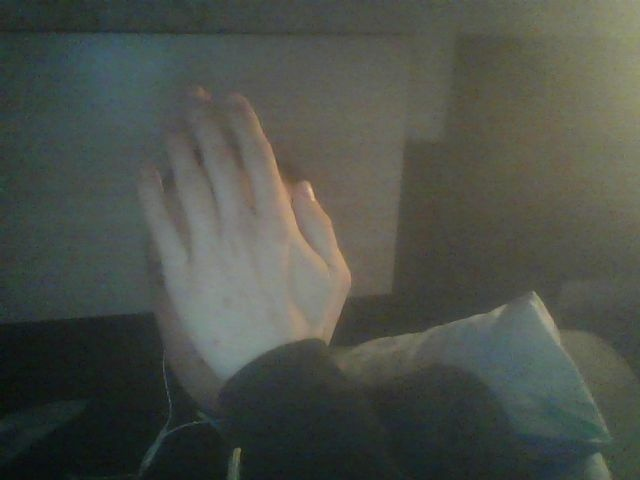

In [31]:
# Read images with OpenCV.
images = {name: cv2.imread(name) for name in uploaded.keys()}

# Preview the images.
for name, image in images.items():
  print(name)   
  cv2_imshow(image)

Handedness of photo (2).jpg:
[classification {
  index: 0
  score: 0.9979830980300903
  label: "Left"
}
]
Hand landmarks of photo (2).jpg:
Index finger tip coordinate: ( 398.1620407104492, 103.04616451263428)


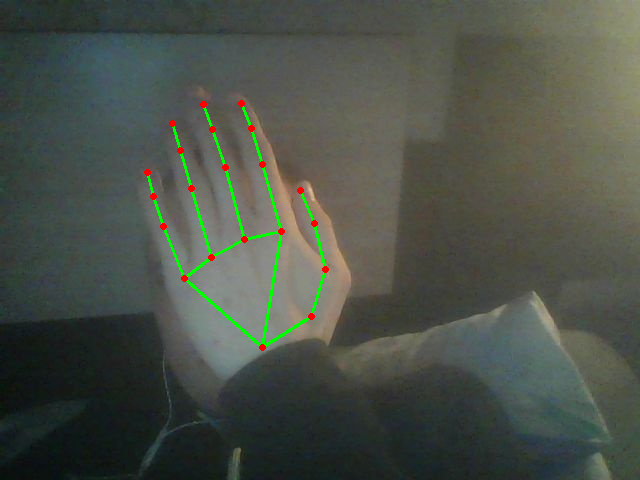

In [32]:
mp_drawing = mp.solutions.drawing_utils 

for name, image in images.items():
  # Convert the BGR image to RGB, flip the image around y-axis for correct 
  # handedness output and process it with MediaPipe Hands.
  results = hands.process(cv2.flip(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1))
  image_hight, image_width, _ = image.shape
  # Print handedness (left v.s. right hand).
  print(f'Handedness of {name}:')
  print(results.multi_handedness)

  # Draw hand landmarks of each hand.
  print(f'Hand landmarks of {name}:')
  if not results.multi_hand_landmarks:
    continue
  annotated_image = cv2.flip(image.copy(), 1)
  for hand_landmarks in results.multi_hand_landmarks:
    # Print index finger tip coordinates.
    print(
        f'Index finger tip coordinate: (',
        f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width}, '
        f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_hight})'
    )
    mp_drawing.draw_landmarks(
        annotated_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
  cv2_imshow(cv2.flip(annotated_image, 1))

In [33]:
hand_landmarks.landmark

[x: 0.5895090699195862
y: 0.7244085073471069
z: -4.8440204409416765e-05
, x: 0.5130347609519958
y: 0.6588696241378784
z: 0.012898244895040989
, x: 0.49067312479019165
y: 0.5621073842048645
z: -0.0009217639453709126
, x: 0.5089808702468872
y: 0.46602535247802734
z: -0.004234714899212122
, x: 0.531069815158844
y: 0.39754289388656616
z: -0.0029072624165564775
, x: 0.5596650838851929
y: 0.4825793206691742
z: -0.09123340994119644
, x: 0.5900043845176697
y: 0.34298789501190186
z: -0.10715410858392715
, x: 0.607598066329956
y: 0.26789867877960205
z: -0.10110355913639069
, x: 0.6221281886100769
y: 0.2146795094013214
z: -0.0946815088391304
, x: 0.6183116436004639
y: 0.49961885809898376
z: -0.09419339895248413
, x: 0.6482799649238586
y: 0.34991005063056946
z: -0.11758392304182053
, x: 0.6673456430435181
y: 0.2692134976387024
z: -0.10983245819807053
, x: 0.6820268630981445
y: 0.21667134761810303
z: -0.09998396039009094
, x: 0.6701018810272217
y: 0.5354414582252502
z: -0.08948446810245514
, x: 0.7

## Описание вспомогательных функций

In [34]:
# Функция по изображению и особым точкам возвращает bbox ладони
def get_palm_coords(landmark, img_shape):
  points = []
  x_max = - np.inf
  x_min = np.inf
  y_max = - np.inf
  y_min = np.inf
  for point in hand_landmarks.landmark:
    points.append((int(point.x*img_shape[1]), int(point.y*img_shape[0])))
    if point.x > x_max:
      x_max = point.x
    if point.x < x_min:
      x_min = point.x
    if point.y > y_max:
      y_max = point.y
    if point.y < y_min:
      y_min = point.y
  
  # координаты Bbox ладони определяется через минимальные и максимальные
  # координаты точек ладони, нормируются в соответствии с размером изображения
  # и увеличиваются на величину зазора
  x_min = int(x_min*img_shape[1] - img_shape[1]*0.1)
  y_min = int(y_min*img_shape[0] - img_shape[0]*0.1)
  x_max = int(x_max*img_shape[1] + img_shape[1]*0.1)
  y_max = int(y_max*img_shape[0] + img_shape[0]*0.1)
  palm = (x_min, y_min, x_max, y_max)
  return palm, tuple(points)

In [35]:
# Функция для вырезания изображений рук
def crop_palms(frame, boxes):
  palms = []
  for i, box in enumerate(boxes):
    palms.append(frame[int(box[1]):int(box[3]), int(box[0]):int(box[2])])
  return palms

In [36]:
# Функция для вырезания изображения руки
def crop_palm(frame, box):
  return frame[int(box[1]):int(box[3]), int(box[0]):int(box[2])]

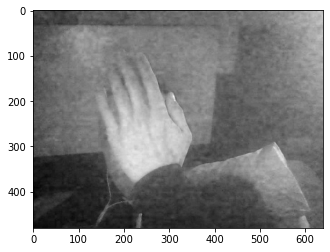

In [37]:
image = np.asarray(image).astype('float')[:,:,0]
image = torch.as_tensor(image)/255
# Отобразим эту картинку
plt.imshow(image, cmap='gray')
plt.show()
image = image.unsqueeze(0)

## Загрузка модели, обученной в PyTorch_classifier_1.ipynb

In [38]:
# Загрузим модель, которая будет классифицировать жест по картинке, вырезанной
# из исходного изображения (вырезать будем по границам bbox'а)
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64*4*4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(-1, 64*4*4)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [39]:
# Загружаем сохраненную модель, обученную в PyTorch_classifier_1.ipynb, и переводим в режим тестирования
net = torch.load('hand_model.pth')
net.eval()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## Запуск основной программы по распознаванию жестов с вэбкамеры

In [40]:
font = cv2.FONT_HERSHEY_SIMPLEX

In [41]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # Перевод изображения в серый цвет
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


    try:
    # Обнаружение координат рук
      results = hands.process(img)
      #print(boxes)
      for hand_landmarks in results.multi_hand_landmarks:
        # Получение координат bbox и основных точек кисти
        box, points = get_palm_coords(hand_landmarks, img.shape)

        # Вывод bbox кисти
        bbox_array = cv2.rectangle(bbox_array, (box[0],box[1]), (box[2],box[3]), (255,0,0), 2)
        # Вырезаем из исходного изображения руку по линии bbox
        palm = crop_palm(gray, box)
        palm = torch.as_tensor(palm)/255
        # Добавляем измерение канала
        palm = palm.unsqueeze(0)
        # Добавляем батч измерение
        palm = palm.unsqueeze(0)
        palm = palm.to(device)
        
        
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с HхW на 256х256
        # clamp не позволяет выйти за границы
        palm = F.interpolate(input=palm, size=256, align_corners=False, mode='bicubic').clamp(min=0, max=1)
        # Возвращаемся к 3-м измерениям
        #palm = palm.squeeze(1)
        result = net(palm)
        result = torch.argmax(result, dim=1)
        result = index_to_class[result.item()]
        #print(result)
        
        # Вывод класса
        bbox_array = cv2.putText(bbox_array, result, (50,50), font, 2, (255,0,0))

        # Вывод основных точек кисти
        for point in points:
          bbox_array = cv2.circle(bbox_array, point, 5, (255,0,0),2)
        

        bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
        # convert overlay of bbox into bytes
        bbox_bytes = bbox_to_bytes(bbox_array)
        # update bbox so next frame gets new overlay
        bbox = bbox_bytes
    except Exception as e:
                pass
                #print('Something wrong im main cycle!')
                #print(f'error : {e}')

    try:
    # Обнаружение координат лиц
      boxes, probs, landmarks = mtcnn.detect(img, landmarks=True)
      for box in boxes:

        # get face bounding box for overlay
        bbox_array = cv2.rectangle(bbox_array,(box[0],box[1]),(box[2],box[3]),color=(0,0,255),thickness=2)

        bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
        # convert overlay of bbox into bytes
        bbox_bytes = bbox_to_bytes(bbox_array)
        # update bbox so next frame gets new overlay
        bbox = bbox_bytes
    except Exception as e:
                pass
                #print('Something wrong im main cycle!')
                #print(f'error : {e}')

    


<IPython.core.display.Javascript object>